In [115]:
import os
from astropy.io import fits
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import requests

from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

In [2]:
allstar = at.Table.read('/Users/apricewhelan/data/APOGEE_DR16/allStarLite-r12-l33.fits')

In [31]:
snr_mask = (allstar['SNR'] > 300)
vsini_mask = (allstar['VSINI'] < 5)
qual_mask = (allstar['ASPCAPFLAG'] & np.sum(2**np.array([7, 23]))) == 0
snr_mask.sum(), vsini_mask.sum(), qual_mask.sum()

(88649, 376486, 348987)

In [32]:
mh_mask = (allstar['M_H'] > -0.2) & (allstar['M_H'] < 0.2)

_mask = snr_mask & vsini_mask & qual_mask & mh_mask
print(_mask.sum())

29497


(5.0, 0.0)

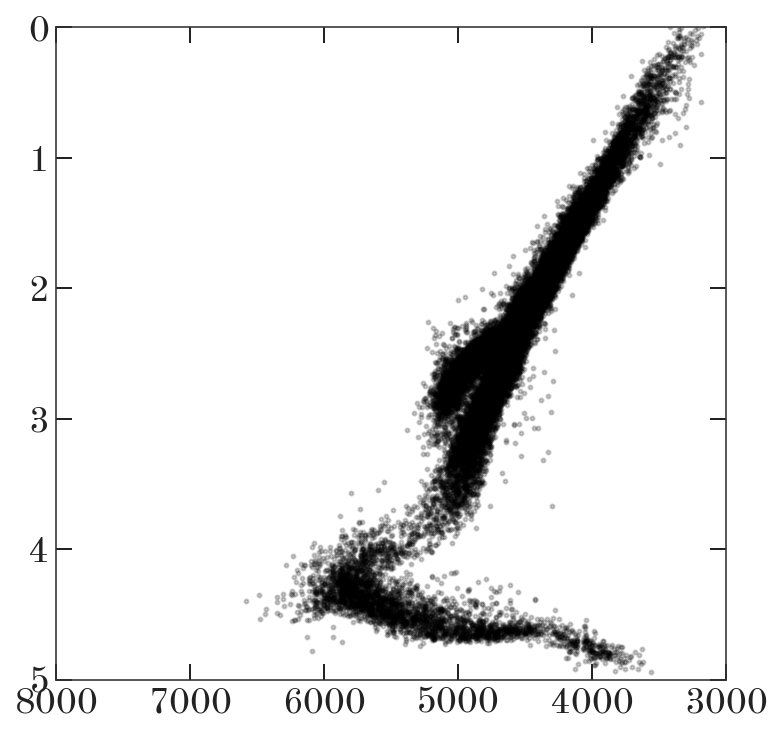

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(allstar[_mask]['TEFF'],
           allstar[_mask]['LOGG'],
           s=4, alpha=0.2)
ax.set_xlim(8000, 3000)
ax.set_ylim(5, 0)

In [45]:
download_path = './spectra'
os.makedirs(download_path, exist_ok=True)

In [131]:
tbins = np.arange(3600, 6500+1, 60)

teff_files = []
teffs = []
for i, (l, r) in enumerate(zip(tbins[:-1], tbins[1:])):
    tmask = (_mask & 
             (allstar['TEFF'] > l) & (allstar['TEFF'] < r) & 
             (allstar['LOGG'] > 4))
    ctr = 0.5 * (l + r)
    if tmask.sum() < 3:
        break    
    
    tmp = []
    for i in range(3):
        r = allstar[tmask][i]

        if r['TELESCOPE'] == 'apo25m':
            ps = 'p'
        else:
            ps = 's'
        url_file = f"{r['TELESCOPE']}/{r['FIELD']}/aspcapStar-r12-{r['APOGEE_ID']}.fits"
        url = f"https://dr16.sdss.org/sas/dr16/apogee/spectro/aspcap/r12/l33/{url_file}"

        local_file = os.path.join(download_path, f"aspcapStar-r12-{r['APOGEE_ID']}.fits")
        if not os.path.exists(local_file):
            req = requests.get(url, allow_redirects=True)
            with open(local_file, 'wb') as f:
                f.write(req.content)

        tmp.append(local_file)
    teff_files.append(tmp)
    teffs.append(ctr)

In [142]:
allflux = np.zeros((len(teff_files), 8575))

for i, filenames in enumerate(teff_files):
    twoflux = np.zeros((len(teff_files[0]), 8575))
    twoerr = np.zeros((len(teff_files[0]), 8575))
    for j, filename in enumerate(filenames):
        hdul = fits.open(filename)
        twoflux[j] = hdul[1].data
        twoerr[j] = hdul[2].data
    
    combined = np.sum(twoflux / twoerr**2, axis=0) / np.sum(1 / twoerr**2, axis=0)
        
    allflux[i] = gaussian_filter1d(combined, sigma=1)
    flux[twoerr[0] == 0] = np.nan

/Users/apricewhelan/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/apricewhelan/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


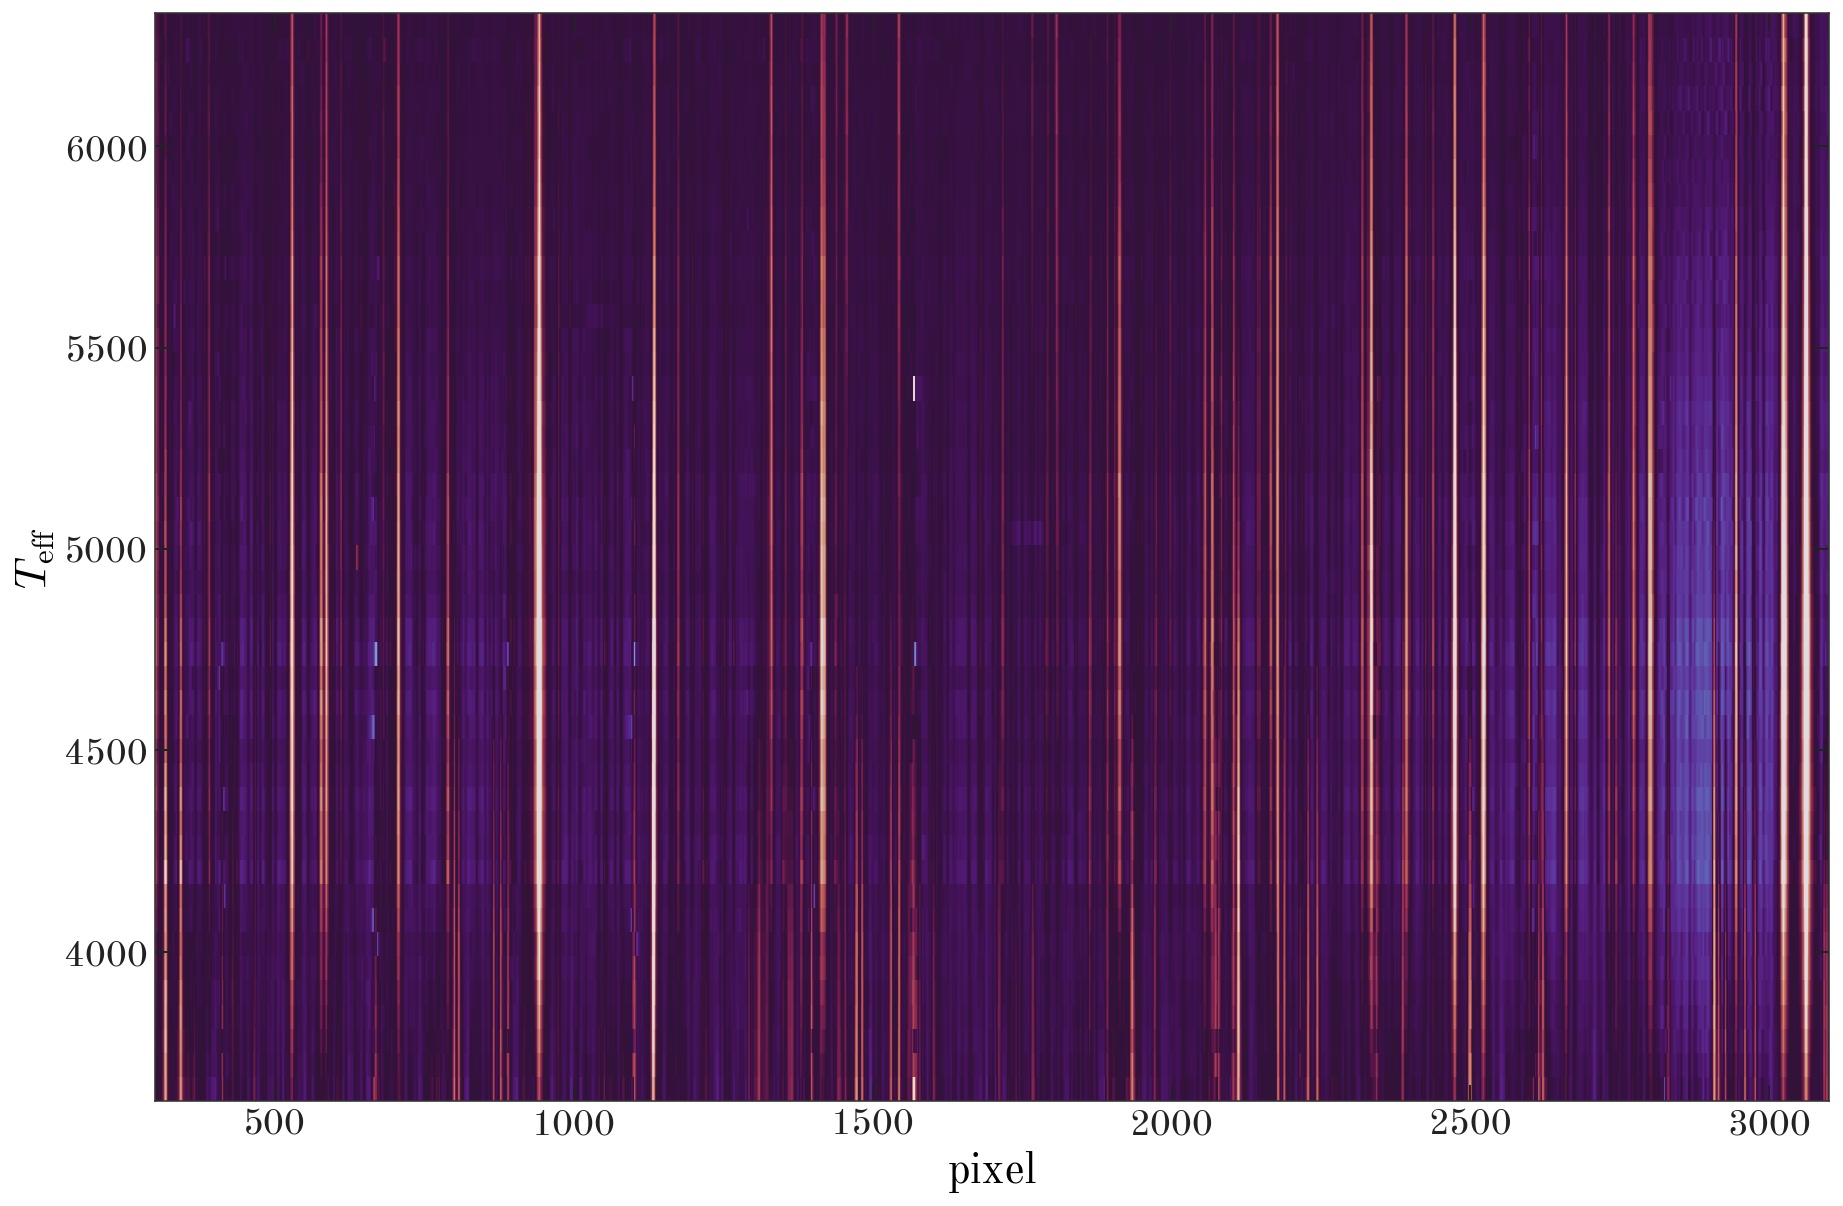

In [153]:
fig = plt.figure(figsize=(15, 10))
plt.pcolormesh(idx, teffs, allflux, cmap='twilight_r',
               vmin=0.75, vmax=1.25)
plt.xlim(300, 3100)
plt.xlabel('pixel')
plt.ylabel(r'$T_{\rm eff}$')
fig.set_facecolor('w')